In [4]:
!pip3 install tdmclient --upgrade

In [57]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [1]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import kalman_filter
from test import *

# Import tdmclient Notebooks environment:

#await tdmclient.notebook.start()

# Functions

In [5]:
@tdmclient.notebook.sync_var 
def set_position(x, y):
    global position
    position[0] = x
    position[1] = y

@tdmclient.notebook.sync_var 
def set_target(x, y):
    global target
    target[0] = x
    target[1] = y


@tdmclient.notebook.sync_var 
def set_arrive(arr):
    global arrived
    arrived = arr

@tdmclient.notebook.sync_var
def get_arrive():
    global arrived
    return arrived


# Main Thymio Code 

In [66]:
%%run_aseba
# temporary variable
var tmp = 0
# robot position
var position[2] = 0,0
# robot direction
var direction[2] = 0,0
# target position
var target[2] = 0,0
# robot to target vector
var targetdir[2] = 0,0
#robot direction relative to the target
# alpha[0] -> cos alpha
# alpha[1] -> sin alpha
var alpha[2] = 0,0
# distance to target
var distance = 0
# internal position and angle estimation
var internal_pos_est[3] = 0,0,0
var shift_left = 0
var shift_right = 0
var shift_center = 0
# time step for motor speed update
var dt = 10         
# speed
var speedf = 100
var speedr = 100
var output_speed_right = 0
var output_speed_left  = 0

var mindist = 100
var ANGLE_TOLERANCE = 500
var deltadirection[2] = 0,0
# boolean to know if the robot arrived at the target
var arrived = 0

# activates each dt ms
timer.period[0] = 5*dt
# activates each 1000 ms
timer.period[1] = dt 




# on timer0 event, we update the direction of the robot and it's motor speeds
onevent timer0
    # output speed
    motor.left.target = output_speed_left
    motor.right.target = output_speed_right
    
# internal position and angle estimation (for kalman)
    # step 1: update left, right and center shift(deplacement)
    shift_left  = output_speed_left * dt / 1000
    shift_right = output_speed_left * dt / 1000
    shift_center = (shift_left + shift_right) / 2
    # step 2: update angle theta ( corresponds to the wheel distance)
    internal_pos_est[2] = internal_pos_est[2] + (shift_right - shift_left)
    # step 3: update position
    call math.sin(direction[0], internal_pos_est[2])
    call math.cos(direction[1], internal_pos_est[2])
    internal_pos_est[1] = internal_pos_est[1] + shift_center * direction[0]/10000
    internal_pos_est[0] = internal_pos_est[0] + shift_center * direction[1]/10000
    
    # remove this when integrating kalman filter
    # internal_pos_est is only used by kalman, not by the robot itself
    position[0] = internal_pos_est[0]
    position[1] = internal_pos_est[1]
    
# calculate the difference between the target and the current position to get the direction vector
    
    # position and direction should come from kalman filter
    call math.sub(direction, target, position) 

    # calculate alpha (angle between the robot direction and the target direction)
    call math.dot(alpha[0], targetdir, direction, 0)
    deltadirection[0] = direction[0]
    deltadirection[1] = -direction[1]
    call math.dot(alpha[1], targetdir, deltadirection,0)
    # calculate the distance to the target ()
    if direction[0] < 0 then
        distance = -direction[0]
    end
    if direction[1] < 0 then
        distance = -direction[1]
    end
    # manhattan distance, to avoid overflow in the the multiplication
    distance = direction[0] + direction[1]

    
    
    
onevent timer1
    if distance <= mindist then
        output_speed_left = 0
        output_speed_right = 0
        arrived = 1
    else 
        # goal is forward
        if alpha[0] >= 1500 - ANGLE_TOLERANCE  or alpha[0] <= 1500 + ANGLE_TOLERANCE then
            # update the motor speeds, alpha[1] will determine the turning force
            output_speed_left  = speedf + speedr * alpha[1]
            output_speed_right = speedf - speedr * alpha[1]
        # goal is backward, need to turn
        else 
            if alpha[1] > ANGLE_TOLERANCE then
                # turn left
                output_speed_left  = -speedf - speedr * alpha[1]
                output_speed_right =  speedf + speedr * alpha[1]
            elseif alpha[1] < ANGLE_TOLERANCE then
                # turn right
                output_speed_left  =  speedf - speedr * alpha[1]
                output_speed_right = -speedf + speedr * alpha[1]
            end
        end
    end 

In [67]:
set_target(100,200)


# Overseer Code

## Camera and Computer Vision setup

In [4]:
#read_camera(-7)
obst, robot, goal, frame = cv_start(show_image= True,exposure=-6)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)
print("obstacles")
for o in obst:
    print(o)

print("robot")
print(robot)
print("goal")
print(goal)

1
2
3
4
5
6
7
8
9
10
11
Either the robot or the goal is not visible/detectable


ValueError: too many values to unpack (expected 4)

## Augmented Dijkstra

path
[243 174]
[329 337]
[661 117]
[812 201]
[984 341]


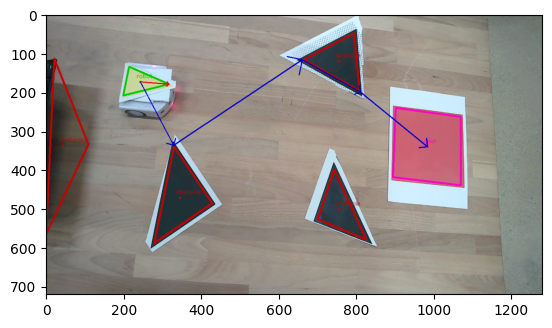

In [10]:
# execute dijkstra
start = [robot[0],robot[1]]
path = compute_shortest_path(obst, start, goal)
path = np.rint(path).astype(int)

print("path")
for p in path:
    print(p)

draw_path(frame, path)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


## Kalman Setup

In [11]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
filter = kalman_filter(robot[0], 0, robot[0], 0, robot[2], 0)
print("Initial state: ", filter.x)

Initial state:  [243.00 0.00 243.00 0.00 0.08 0.00]


## Global Navigation

In [2]:
min_distance = 100
position_estimate = np.zeros(3)
path = [[150,150], [100,100], [200,100]]

filter = kalman_filter(position_estimate[0],0,position_estimate[1],0,position_estimate[2],0)
distance = np.sqrt((target[0]-position_estimate[0])**2 + (target[1]-position_estimate[1])**2)


for target in path:
    while distance > min_distance:
        distance = pathing_bis(position_estimate[0:1], position_estimate[2], target)
        print(distance)
        position_estimate = filter.update(position_estimate)





NameError: name 'target' is not defined